# Train, Validate, Test pty-co-SAXSNN

## Import necessary packages

In [1]:
import os
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
from tqdm import tqdm
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/utils/')))
from loss_functions import NPCC_loss_symmetry_penalty, NPCC_loss, L1_loss, L2_loss

plt.rcParams["image.cmap"] = "jet"

## Set paths

In [2]:
# Setting path
# path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs/")
# path = Path("/scratch/")

# Join paths
MODEL_SAVE_PATH = path / 'ptycoSAXSNN/example/03_Train_Validation_Test/trained_model/' # Automatically adds the correct separator

# Create the directory (including any missing parent directories) if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print(MODEL_SAVE_PATH)

/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/example/03_Train_Validation_Test/trained_model


## Load preprocessed data

In [3]:
# Load preprocessed data
directory='Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256'

# Number of diffraction patterns to use
numDPs=960

# Load the data
data_path = os.path.abspath(os.path.join(os.getcwd(), path / f'ptycoSAXSNN/example/02_Preprocess/preprocessed_sim_{directory}.npz'))
data = np.load(data_path)

# Extract the arrays
log_conv_red = data['log_conv_red']
log_ideal_red = data['log_ideal_red']

## Set number of patterns in train, test, or validation sets

In [4]:
# Set the number of patterns in test, train or validation set
NTEST = log_conv_red.shape[0]//4
NTRAIN = log_conv_red.shape[0]-NTEST
NVALID = NTEST//2 # NTRAIN//

print(NTRAIN,NTEST,NVALID)

720 240 120


## Set GPUs, batch size, learning rate

In [ ]:
EPOCHS = 10
# Specify which GPUs to use (e.g. GPUs 1 and 2)
selected_gpus = [1,3]  # Yes, this will use the first 3 GPUs (0, 1, and 2)
NGPUS = len(selected_gpus)
#NGPUS = torch.cuda.device_count()#1
BATCH_SIZE = NGPUS*16
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

H,W=log_ideal_red[0].shape[0],log_ideal_red[0].shape[1]
print(H,W)

GPUs: 2 Batch size: 32 Learning rate: 0.002
256 256


## Separate data and convert to tensors and shuffle. Set data to DataLoaders

In [ ]:
tst_start = log_conv_red.shape[0]-NTEST

X_train = log_conv_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = log_conv_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Y_I_train = log_ideal_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = log_ideal_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

X_train,Y_I_train = shuffle(X_train, Y_I_train, random_state=0)

#Training data
X_train_tensor = torch.Tensor(X_train)
Y_I_train_tensor = torch.Tensor(Y_I_train) 

#Test data
X_test_tensor = torch.Tensor(X_test)
Y_I_test_tensor = torch.Tensor(Y_I_test) 

print(X_train_tensor.shape, Y_I_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor)
test_data = TensorDataset(X_test_tensor)

N_TRAIN = X_train_tensor.shape[0]

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-NVALID,NVALID])
print(len(train_data2),len(train_data2[0]),len(valid_data),len(test_data))

#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([720, 1, 256, 256]) torch.Size([720, 1, 256, 256])
600 2 120 240


## Initialize model

In [ ]:
# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/models/')))

try:
    import encoder1
    importlib.reload(encoder1)
    
    # Now import the class from the freshly reloaded module
    from encoder1 import recon_model
    print("Successfully imported recon_model")
    unet_status = "Unet" #no_Unet
    loss_function = "pearson_loss" #L2, L1
except Exception as e:
    print(f"Import error: {e}")

model = recon_model()
load_prev_model=False

Successfully imported recon_model


## Distribute model across multiple GPUs (and also load previous model if desired)

In [8]:
for I,O in trainloader:
    print("batch size:", I.shape)
    O_pred = model(I)
    print(O_pred.shape)
    print(O_pred.dtype)
    break

device = torch.device(f"cuda:{selected_gpus[0]}" if torch.cuda.is_available() else "cpu")
device_ids = selected_gpus  # This will use only the specified GPUs


if load_prev_model:
    MODEL_LOAD_PATH = '/scratch/trained_model/best_model_ZCB_9_3D_S5065_N1200_steps3_dp256_Unet_epoch_500_pearson_loss.pth'
    model.load_state_dict(torch.load(MODEL_LOAD_PATH))
    print("Loaded previous model")

if NGPUS > 1:
    print("Let's use", NGPUS, "GPUs!")
    #model = nn.parallel.DistributedDataParallel(model) #Default all devices
    model = nn.DataParallel(model, device_ids=device_ids)  # Explicitly specify which GPUs to use

model = model.to(device)
print(model)

batch size: torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32
Let's use 2 GPUs!
DataParallel(
  (module): recon_model(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder3): Sequential(
      (0): Co

# Train, Validate, Test pty-co-SAXSNN

In [9]:
#Optimizer details
iterations_per_epoch = np.floor((NTRAIN-NVALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch 
print(iterations_per_epoch)
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

#criterion = nn.L1Loss()
#criterion = nn.MSELoss()
    
optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
                                              
#Function to update saved model if validation loss is minimum

def update_saved_model(model, path, current_epoch, best_val_loss):
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Save the best overall model
    if (NGPUS>1):    
        torch.save(model.module.state_dict(), path / f'best_model_{directory}_{unet_status}_{loss_function}.pth')
    else:
        torch.save(model.state_dict(), path / f'best_model_{directory}_{unet_status}_{loss_function}.pth')
    
    # Define epoch intervals (50, 100, 150, etc.)
    epoch_intervals = [2, 10, 25, 50, 100, 150, 200, 250]
    
    # For each interval, save the best model within that interval
    for interval in epoch_intervals:
        if current_epoch <= interval:
            # Create a filename that includes the epoch interval
            interval_filename = f'best_model_{directory}_{unet_status}_epoch_{interval}_{loss_function}.pth'
            interval_path = path / interval_filename
            
            # If this is the first time we're saving for this interval, save the model
            if not interval_path.exists():
                if (NGPUS>1):
                    torch.save(model.module.state_dict(), interval_path)
                else:
                    torch.save(model.state_dict(), interval_path)
                print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")
            # If we already have a model for this interval, only update if the current loss is better
            else:
                # Load the previous best loss for this interval
                prev_loss_path = path / f'best_loss_epoch_{directory}_{unet_status}_{interval}_{loss_function}.txt'
                if prev_loss_path.exists():
                    with open(prev_loss_path, 'r') as f:
                        prev_best_loss = float(f.read().strip())
                    
                    # Update if current loss is better
                    if best_val_loss < prev_best_loss:
                        if (NGPUS>1):
                            torch.save(model.module.state_dict(), interval_path)
                        else:
                            torch.save(model.state_dict(), interval_path)
                        with open(prev_loss_path, 'w') as f:
                            f.write(str(best_val_loss))
                        print(f"Updating best model for epoch interval {interval} at epoch {current_epoch}")
                else:
                    # First time saving for this interval
                    if (NGPUS>1):
                        torch.save(model.module.state_dict(), interval_path)
                    else:
                        torch.save(model.state_dict(), interval_path)
                    with open(prev_loss_path, 'w') as f:
                        f.write(str(best_val_loss))
                    print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")



def train(trainloader,metrics):
    tot_loss = 0.0
    tot_loss_amp = 0.0
    tot_loss_symmetry = 0.0
    
    for i, (ft_images,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass
        
        #Compute losses
        #loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_a,loss_pearson,loss_symmetry = NPCC_loss_symmetry_penalty(pred_amps,amps)
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        tot_loss_amp += loss_pearson.detach().item()
        tot_loss_symmetry += loss_symmetry.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,tot_loss_amp/i,tot_loss_symmetry/i]) 
    
def validate(validloader,metrics):
    tot_val_loss = 0.0
    tot_val_loss_amp = 0.0
    tot_val_loss_symmetry = 0.0
    for j, (ft_images,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass

        #val_loss_a = criterion(pred_amps,amps)
        val_loss_a,val_loss_pearson,val_loss_symmetry = NPCC_loss_symmetry_penalty(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        tot_val_loss_amp += val_loss_pearson.detach().item()
        tot_val_loss_symmetry += val_loss_symmetry.detach().item()
        
    metrics['val_losses'].append([tot_val_loss/j,tot_val_loss_amp/j,tot_val_loss_symmetry/j])
  
    #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH, metrics['current_epoch'], tot_val_loss/j)
        
        



19.0
LR step size is: 114.0 which is every 6 epochs


# Train, Validate, Test pty-co-SAXSNN

In [10]:
# Initialize metrics dictionary with current_epoch
metrics = {
    'losses': [],
    'val_losses': [],
    'lrs': [],
    'best_val_loss': float('inf'),
    'current_epoch': 0
}

for epoch in range (EPOCHS):
    metrics['current_epoch'] = epoch  # Update current epoch in metrics
    
    #Set model to train mode
    model.train() 
    #Training loop
    train(trainloader,metrics)
    
    #Switch model to eval mode
    model.eval()
    
    #Validation loop
    validate(validloader,metrics)
    print('Epoch: %d | Total  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
    print('Epoch: %d | Amp | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
    print('Epoch: %d | Symmetry | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
    print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

0it [00:00, ?it/s]/home/beams/PTYCHOSAXS/miniconda3/envs/ptychosaxs_v1/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
19it [00:04,  4.11it/s]


Saving improved model after Val Loss improved from inf to 0.80957
Epoch: 0 | Total  | Train Loss: 0.47580 | Val Loss: 0.80957
Epoch: 0 | Amp | Train Loss: 0.47580 | Val Loss: 0.80957
Epoch: 0 | Symmetry | Train Loss: 0.05182 | Val Loss: 0.07314
Epoch: 0 | Ending LR: 0.000500 


19it [00:02,  7.17it/s]


Epoch: 1 | Total  | Train Loss: 0.34309 | Val Loss: 1.16077
Epoch: 1 | Amp | Train Loss: 0.34309 | Val Loss: 1.16077
Epoch: 1 | Symmetry | Train Loss: 0.01891 | Val Loss: 0.03173
Epoch: 1 | Ending LR: 0.000800 


19it [00:02,  7.18it/s]


Saving improved model after Val Loss improved from 0.80957 to 0.70798
Epoch: 2 | Total  | Train Loss: 0.31444 | Val Loss: 0.70798
Epoch: 2 | Amp | Train Loss: 0.31444 | Val Loss: 0.70798
Epoch: 2 | Symmetry | Train Loss: 0.01871 | Val Loss: 0.01673
Epoch: 2 | Ending LR: 0.001100 


19it [00:02,  7.15it/s]


Saving improved model after Val Loss improved from 0.70798 to 0.50049
Epoch: 3 | Total  | Train Loss: 0.28896 | Val Loss: 0.50049
Epoch: 3 | Amp | Train Loss: 0.28896 | Val Loss: 0.50049
Epoch: 3 | Symmetry | Train Loss: 0.01534 | Val Loss: 0.02454
Epoch: 3 | Ending LR: 0.001400 


19it [00:02,  7.11it/s]


Saving improved model after Val Loss improved from 0.50049 to 0.40958
Epoch: 4 | Total  | Train Loss: 0.27923 | Val Loss: 0.40958
Epoch: 4 | Amp | Train Loss: 0.27923 | Val Loss: 0.40958
Epoch: 4 | Symmetry | Train Loss: 0.02117 | Val Loss: 0.02768
Epoch: 4 | Ending LR: 0.001700 


19it [00:02,  7.09it/s]


Epoch: 5 | Total  | Train Loss: 0.25772 | Val Loss: 0.44648
Epoch: 5 | Amp | Train Loss: 0.25772 | Val Loss: 0.44648
Epoch: 5 | Symmetry | Train Loss: 0.01776 | Val Loss: 0.04892
Epoch: 5 | Ending LR: 0.002000 


19it [00:02,  7.12it/s]


Saving improved model after Val Loss improved from 0.40958 to 0.34689
Epoch: 6 | Total  | Train Loss: 0.24007 | Val Loss: 0.34689
Epoch: 6 | Amp | Train Loss: 0.24007 | Val Loss: 0.34689
Epoch: 6 | Symmetry | Train Loss: 0.01796 | Val Loss: 0.02091
Epoch: 6 | Ending LR: 0.001700 


19it [00:02,  7.09it/s]


Epoch: 7 | Total  | Train Loss: 0.23440 | Val Loss: 0.36239
Epoch: 7 | Amp | Train Loss: 0.23440 | Val Loss: 0.36239
Epoch: 7 | Symmetry | Train Loss: 0.02158 | Val Loss: 0.02086
Epoch: 7 | Ending LR: 0.001400 


19it [00:02,  7.09it/s]


Saving improved model after Val Loss improved from 0.34689 to 0.30714
Epoch: 8 | Total  | Train Loss: 0.22334 | Val Loss: 0.30714
Epoch: 8 | Amp | Train Loss: 0.22334 | Val Loss: 0.30714
Epoch: 8 | Symmetry | Train Loss: 0.02195 | Val Loss: 0.02496
Epoch: 8 | Ending LR: 0.001100 


19it [00:02,  7.08it/s]


Saving improved model after Val Loss improved from 0.30714 to 0.28177
Epoch: 9 | Total  | Train Loss: 0.21064 | Val Loss: 0.28177
Epoch: 9 | Amp | Train Loss: 0.21064 | Val Loss: 0.28177
Epoch: 9 | Symmetry | Train Loss: 0.01914 | Val Loss: 0.02365
Epoch: 9 | Ending LR: 0.000800 


# Train, Validate, Test pty-co-SAXSNN

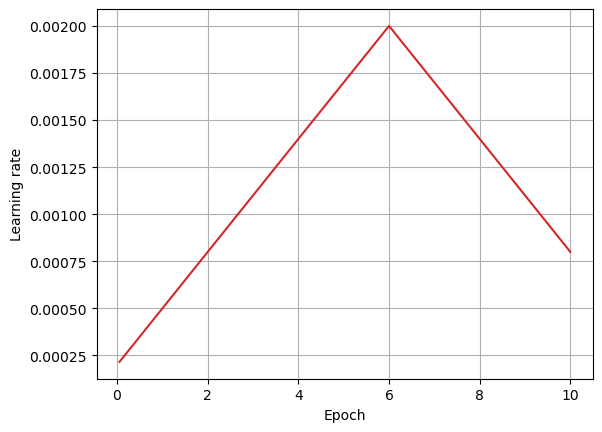

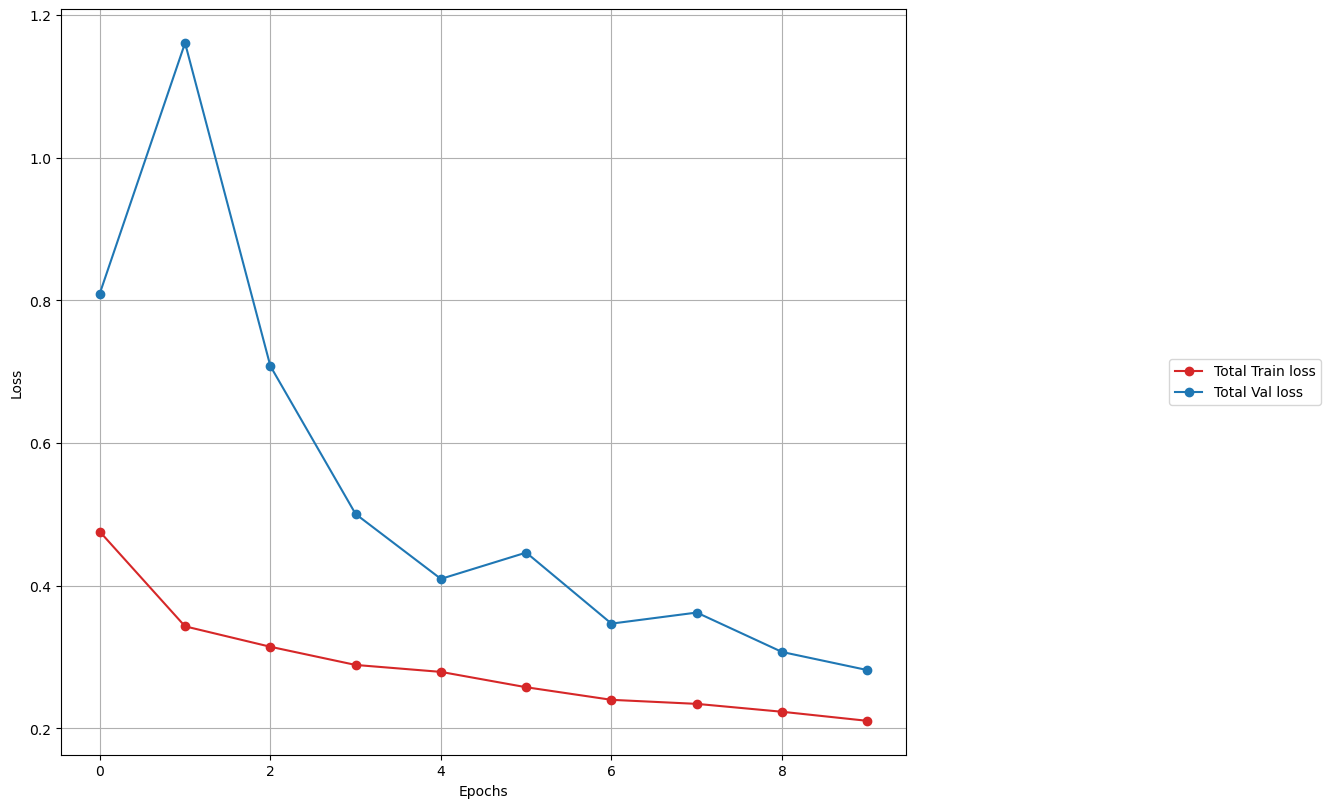

In [17]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.figure()
plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")
plt.savefig(f'/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/example/03_Train_Validation_Test/plots/{directory}_{unet_status}_{loss_function}_learning_rate.png', bbox_inches='tight', dpi=300)
plt.show()


losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.xlabel("Epochs")
plt.savefig(f'/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/example/03_Train_Validation_Test/plots/{directory}_{unet_status}_{loss_function}_train_loss.png', bbox_inches='tight', dpi=300)
plt.show()

# Train, Validate, Test pty-co-SAXSNN

<Figure size 640x480 with 0 Axes>

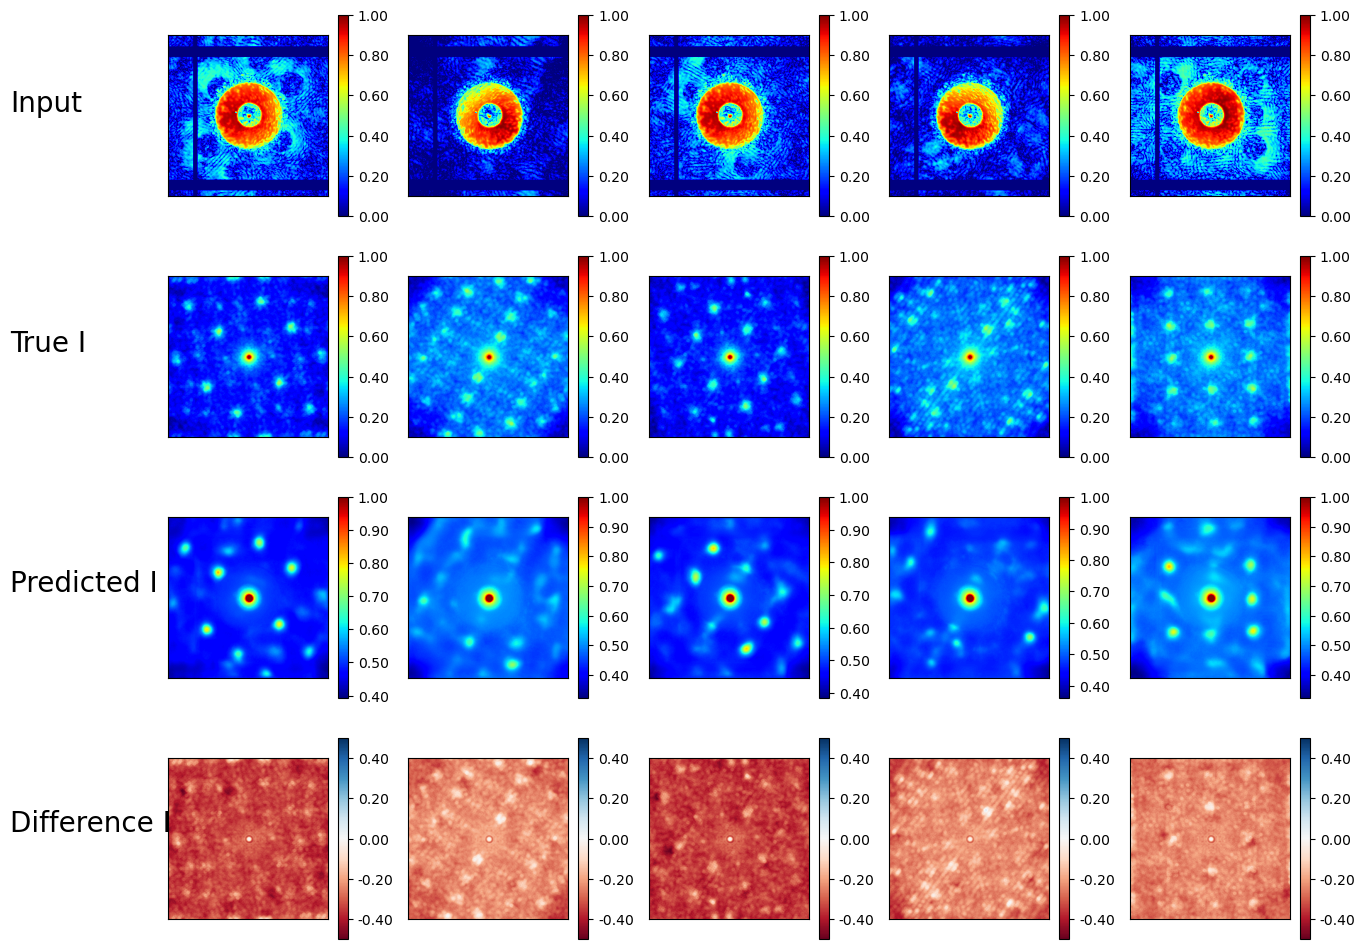

In [18]:
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    result = model(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()



h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w), vmin=0, vmax=1)
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#, vmin=0.0, vmax=1)
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w), 
                      vmin=-0.5, vmax=0.5, cmap='RdBu')
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.savefig(f'/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/example/03_Train_Validation_Test/plots/{directory}_{unet_status}_{loss_function}_test.png', bbox_inches='tight', dpi=300)
plt.show()          